<a href="https://colab.research.google.com/github/mvajhi/unsupervised-learning/blob/master/HW3/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the dataset
The dataset can be downloaded directly into your Google Colab environment using the [Kaggle API](https://www.kaggle.com/docs/api) as shown below. You can refer to this [post](https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235) on Medium for more details.

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

Upload Kaggle.json downloaded from your registered kaggle account

In [2]:
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [3]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:12<00:00, 268MB/s]
100% 1.33G/1.33G [00:12<00:00, 116MB/s]


In [4]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

Caution (for Colab users) : Do not attempt to explore the directory using the viewer on the left as the page becomes unresponsive owing to the large size of the dataset.

### Imports

In [46]:
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator # اصلاح شد
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from tensorflow.keras import backend as K # اصلاح شد
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

### Data

In [47]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


Since the dataset is quite large, we shall create an <i>ImageDataGenerator</i> object and employ its member function - <i>flow_from_directory</i> to define the flow of data directly from disk rather than loading the entire dataset into memory. The ImageDataGenerator can also be used to dynamically apply various transformations for image augmentation which is particularly useful in the case of small datasets.

I highly encourage you to refer to the [documentation](https://keras.io/preprocessing/image/#flow_from_directory) for understanding the various parameters of the dataflow function.

In [48]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 512
Z_DIM = 200

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER,
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 202599 images belonging to 1 classes.


این کلاس داده ها را بارگزاری می کند همچنین مواردی مانند لیبل زدن بر اساس دایرکتوری و همچنین پیش پردازش هایی مانند اسکیل تصاویر را نیز انجام می دهد همچنین امکان آگمنت کردن تصاویر را نیز می دهد. توجه کنید که این کلاس منسوخ شده.

### MODEL ARCHITECTURE


#### Building the Encoder

In [56]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size,
                  conv_strides):

  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu,
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model
  # would be inconsistent
  global K
  K.clear_session()

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters=conv_filters[i], kernel_size=conv_kernel_size[i], strides=conv_strides[i], padding='same')(x)

      x = LeakyReLU()(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:]

  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, activation='relu')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

<br><br>
The architecture of the Encoder, as shown below, consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size 200.

In [57]:
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM,
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

# use summary method to see the output of the encoder part
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       819,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,648 (3.48 MB)

 Trainable params: 912,648 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

#### Building the Decoder


In [59]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size,
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters=conv_filters[i], kernel_size=conv_kernel_size[i], strides=conv_strides[i], padding='same')(x)

      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

<br><br>
Recall that it is the function of the Decoder to reconstruct the image from the latent vector. Therefore, it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved either through the [UpSampling2D](https://keras.io/layers/convolutional/#upsampling2d) layer or the [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer.

Here, the Conv2DTranspose Layer is employed. This layer produces an output tensor double the size of the input tensor in both height and width.

<i>Note : The Decoder, in this example, is defined to be a mirror image of the encoder, which is not mandatory.</i>

<br><br>

In [60]:
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
# use summary method to see the model of decoder
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       823,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 916,483 (3.50 MB)

 Trainable params: 916,483 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

#### Attaching the Decoder to the Encoder

In [61]:
simple_autoencoder_input = encoder_input

simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

# use summary method to see the model of autoencoder
simple_autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       819,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 128, 128, 3)    │       916,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,829,131 (6.98 MB)

 Trainable params: 1,829,131 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

### COMPILATION AND TRAINING

The loss function used is a simple Root Mean Square Error (RMSE). The true output is the same batch of images that was fed to the model at its input layer. The Adam optimizer is optimizing the RMSE error for encoding the batch of images into their respective latent vectors and subsequently decoding them to reconstruct the images.

The ModelCheckpoint Keras callback saves the model weights for reuse. It overwrites the file with a fresh set of weights after every epoch.

NOTE : If you're using Google Colab, either download the weights to disc or mount your Google Drive.

In [62]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

optimizer = Adam(learning_rate = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

# use compile method in keras to run the model
simple_autoencoder.compile(optimizer = optimizer, loss = r_loss)

# checkpoint_ae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.h5'), save_weights_only = True, verbose=1)
checkpoint_ae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.weights.h5'), save_weights_only = True, verbose=1)


<i>TIP</i> : Here's a really useful tip I found on Reddit (by arvind1096) - to prevent Google Colab from disconnecting due to a timeout issue, execute the following JS function in the Google Chrome console.

<br>
function ClickConnect(){console.log("Working");document.querySelector("colab-toolbar-button#connect").click()}setInterval(ClickConnect,60000)

In [63]:
simple_autoencoder.fit(data_flow,
                                 shuffle=True,
                                 epochs = N_EPOCHS,
                                 initial_epoch = 0,
                                 steps_per_epoch=NUM_IMAGES // BATCH_SIZE,
                                 callbacks=[checkpoint_ae])

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 0.0535
Epoch 1: saving model to ./weights/AE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 283s 684ms/step - loss: 0.0535
Epoch 2/10
  1/395 ━━━━━━━━━━━━━━━━━━━━ 3:52 591ms/step - loss: 0.0151
Epoch 2: saving model to ./weights/AE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step - loss: 0.0151  
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - loss: 0.0140
Epoch 3: saving model to ./weights/AE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 262s 662ms/step - loss: 0.0140
Epoch 4/10
  1/395 ━━━━━━━━━━━━━━━━━━━━ 3:33 543ms/step - loss: 0.0113
Epoch 4: saving model to ./weights/AE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 324us/step - loss: 0.0113  
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - loss: 0.0113
Epoch 5: saving model to ./weights/AE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 262s 663ms/step - loss: 0.0113
Epoch 6/10
  1/395 ━━━━━━━━━━━━━━━━━━━━ 3:30 534ms/step - loss: 0.0102
Epoch 6: saving model to ./weights/AE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step - loss: 0.0102  
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - loss: 0.0102
Epoch 7: saving model to ./weights/AE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 259s 655ms/step - loss: 0.0102
Epoch 8/10
  1/395 ━━━━━━━━━━━━━━━━━━━━ 3:33 542ms/step - loss: 0.0096
Epoch 

### RECONSTRUCTION

The first step is to generate a new batch of images using the ImageDataGenerator defined in the 'Data' section at the top. The images are returned as an array and the number of images is equal to BATCH_SIZE.

In [64]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [65]:
example_images.shape

(10, 128, 128, 3)

#### Displaying the reconstructed images

In [66]:
import matplotlib.pyplot as plt

In [67]:
def plot_compare(images=None, add_noise=False):

  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  if add_noise:
    encodings = simple_autoencoder_input(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = simple_autoencoder_output(encodings)

  else:
    reconst_images = simple_autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


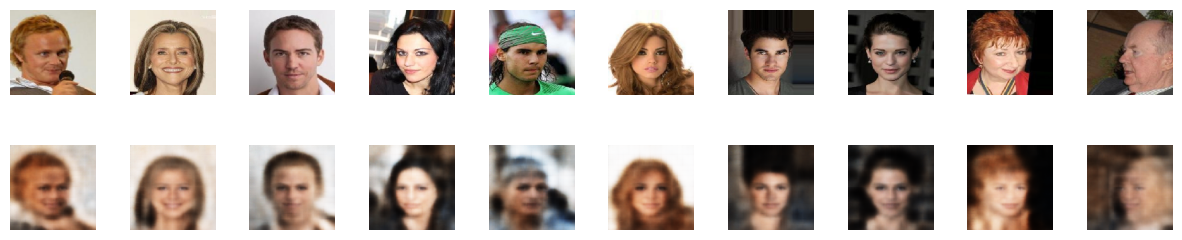

In [68]:
plot_compare(example_images)

The first row shows images directly from the dataset and the second row shows images that have been passed through the Autoencoder. Evidently, the model has learned to encode and decode (reconstruct) fairly well.

NOTE : A reason why the images lack sharpness is due to the RMSE loss as it averages out the differences between individual pixel values. Generative Adversarial Networks on the contrary, produce much sharper images.

## VARIATIONAL AUTOENCODER



#### Building the Encoder


In [69]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size,
                  conv_strides, use_batch_norm = False, use_dropout = False):

  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu,
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model
  # would be inconsistent
  global K
  K.clear_session()

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters=conv_filters[i], kernel_size=conv_kernel_size[i], strides=conv_strides[i], padding='same')(x)
      if use_batch_norm:
        x = BatchNormalization()(x)

      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:]

  x = Flatten()(x)

  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.)
    return mean_mu + K.exp(log_var/2)*epsilon

  # Using a Keras Lambda Layer to include the sampling function as a layer
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [70]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
                                                                                                            input_dim=INPUT_DIM,
                                                                                                            output_dim=Z_DIM,
                                                                                                            conv_filters=[32, 64, 64, 64],
                                                                                                            conv_kernel_size=[3, 3, 3, 3],
                                                                                                            conv_strides=[2, 2, 2, 2],
                                                                                                            use_batch_norm=True,
                                                                                                            use_dropout=True
                                                                                                        )

vae_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 64)  │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,732,944 (6.61 MB)

 Trainable params: 1,732,496 (6.61 MB)

 Non-trainable params: 448 (1.75 KB)

#### Building the Decoder
Since the Decoder remains the same, the Decoder architecture of the Simple Autoencoder is reused.

In [71]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(
                                                        input_dim=Z_DIM,
                                                        shape_before_flattening=vae_shape_before_flattening,
                                                        conv_filters=[64, 64, 32, 3],
                                                        conv_kernel_size=[3, 3, 3, 3],
                                                        conv_strides=[2, 2, 2, 2]
                                                    )

vae_decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │       823,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 916,483 (3.50 MB)

 Trainable params: 916,483 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

#### Attaching the Decoder to the Encoder


In [72]:
#######################################################################
###### in this part you should attach and build the VAE together ######
#######################################################################
vae_input = vae_encoder_input

vae_output = vae_decoder(vae_encoder_output)

vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 64)  │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,649,427 (10.11 MB)

 Trainable params: 2,648,979 (10.11 MB)

 Non-trainable params: 448 (1.75 KB)

### COMPILATION AND TRAINING


The loss function is a sum of RMSE and KL Divergence. A weight is assigned to the RMSE loss, known as the loss factor. The loss factor is multiplied with the RMSE loss. If we use a high loss factor, the drawbacks of a Simple Autoencoder start to appear. However, if we use a loss factor too low, the quality of the reconstructed images will be poor. Hence the loss factor is a hyperparameter that needs to be tuned.

In [73]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

In [74]:
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR * r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [78]:
adam_optimizer = Adam(learning_rate = LEARNING_RATE)

# compile model here
vae_model.compile(optimizer = adam_optimizer, loss = total_loss)

# checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)
checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.weights.h5'), save_weights_only = True, verbose=1)

In [79]:
vae_model.fit(data_flow,
                        shuffle=True,
                        epochs = N_EPOCHS,
                        initial_epoch = 0,
                        steps_per_epoch=NUM_IMAGES // BATCH_SIZE,
                        callbacks=[checkpoint_vae])

Epoch 1/200


ValueError: Tried to convert 'x' to a tensor and failed. Error: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


### RECONSTRUCTION.
The reconstruction process is the same as that of the Simple Autoencoder.

In [ ]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [ ]:
def plot_compare_vae(images=None):

  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

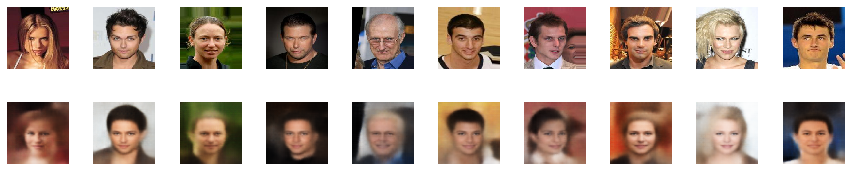

In [ ]:
plot_compare_vae(images = example_images)

### Generating new faces from random vectors sampled from a standard normal distribution.

In [ ]:
def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')
        sub.imshow(img)

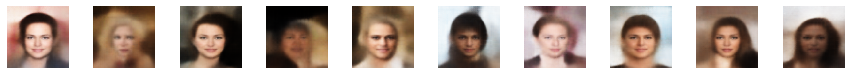

In [ ]:
vae_generate_images(n_to_show=10)